Detailed calculations:
Rows: 8111, Columns: 9
Less than 2% property_type count: 21
Less than 2% room_type count: 1
Rows: 7018, Columns: 8 after pre-processing
latitude: 37.76605
longitude: -122.43011
property_type: Apartment
room_type: Entire home/apt
bathrooms: 1
bedrooms: 1
minimum_nights: 10
price: 200
Output metrics:
MAE: 82.98014423076923
r2: 0.17612857185872244


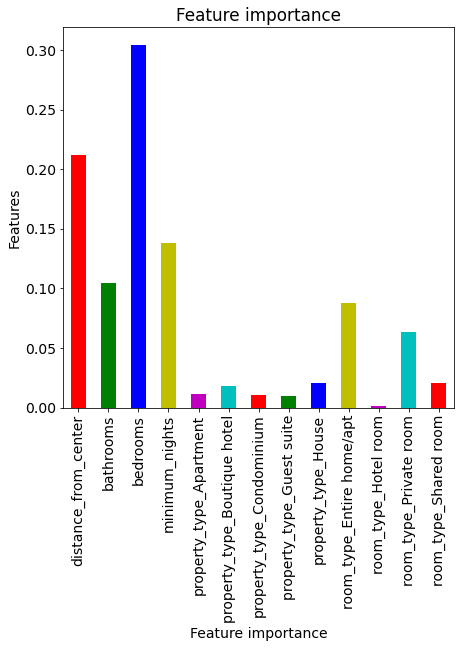

Features: [0.21143444 0.10422566 0.3039844  0.13795562 0.01134014 0.01793694
 0.01045249 0.00933668 0.02062968 0.08768264 0.00129796 0.06300054
 0.0207228 ]
Sum: 1.0
Calculated price: 158.24
Estimated accomodation price per night is more cheaper for more than 25 dollars of actual price     ~ 41.8$ or ~ 26.4%


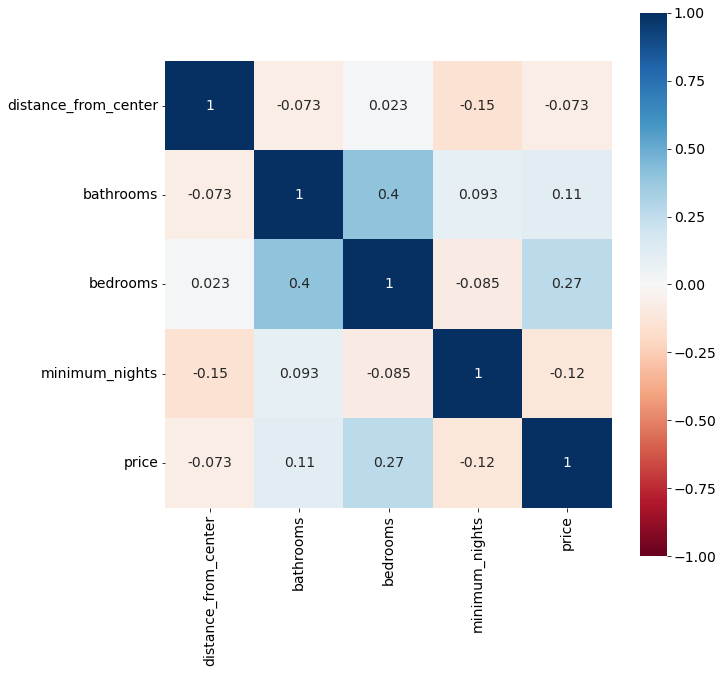

In [4]:
#Copyright (c) Dmitry Moskalev
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from math import cos, asin, sqrt, pi
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import joblib
plt.rcParams['font.size'] = 14.0

df = pd.read_csv('***')

print('Detailed calculations:')
# Unpickle classifier if needed
#rf_reg = joblib.load("rf_reg.pkl")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Clean data, exclude missing values, small % types and use hot-encoding for categorial variables
df = df.drop(columns=['id'])
df = df.dropna()
# Optimize price column as digits
df.price = pd.Series(df.price.str.replace('\..*$|[$,]', '', regex=True))

# Optimize memory and compability with few int columns
df.price = df.price.astype(int)
df.bathrooms = df.bathrooms.astype(int)
df.bedrooms = df.bedrooms.astype(int)
df.minimum_nights = df.minimum_nights.astype(int)

# Short-term rental (stay) period is less than 30 nights:
# https://sfplanning.org/str/faqs-short-term-rentals
df = df.loc[df.minimum_nights <= 30]
df = df.reset_index(drop=True)

# Drop all rows with property_type feature not at least 2% of full dataframe to prevent noise in model fitting
# and increase accuracy by reducing number of classes
rows_noise_property_type = []
for i in list(set(df.property_type)):
    if len(df.loc[df.property_type == i]) < df.shape[0] // 50:
        # print(i, len(df.loc[df.property_type == i]))
        rows_noise_property_type.append(i)

df = df.drop(index=df.loc[df.property_type.isin(rows_noise_property_type)].index)
print(f"Less than 2% property_type count: {len(rows_noise_property_type)}")

rows_noise_room_type = []
for i in list(set(df.room_type)):
    if len(df.loc[df.room_type == i]) < df.shape[0] // 50:
        # print(i, len(df.loc[df.room_type == i]))
        rows_noise_room_type.append(i)
print(f"Less than 2% room_type count: {len(rows_noise_room_type)}")

df = df.drop(index=df.loc[df.property_type.isin(rows_noise_room_type)].index)
df = df.reset_index(drop=True)
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]} after pre-processing")
# Insert user data from Streamlit
df.loc[df.shape[0]] = [37.76605, -122.43011, 'Apartment', 'Entire home/apt', 1, 1, 10, 200]
for count, i in enumerate(df.columns):
    print(f'{str(i)}: {str(df.loc[df.shape[0]-1][count])}')
# Looks like the is San Francisco: https://www.maps.ie/coordinates.html
# latitude_min = df.latitude.min()
# longitude_min = df.longitude.min()
# latitude_max = df.latitude.max()
# longitude_max = df.longitude.max()

# Define the city center coordinates: https://www.latlong.net/place/san-francisco-ca-usa-594.html
latitude_center = 37.773972
longitude_center = -122.431297

# Distance (km)
def distance(lat1, lon1, lat2, lon2):
    p = pi / 180
    distance = 12742 * asin(
        sqrt(0.5 - cos((lat2 - lat1) * p) / 2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2))
    return round(distance, 2)

df.insert(2, 'distance_from_center', '')
df = df.reset_index(drop=True)
for count, i in enumerate(df.distance_from_center):
    df.loc[count, 'distance_from_center'] = distance(latitude_center, longitude_center, df.latitude[count],
                                                     df.longitude[count])

df.distance_from_center = df.distance_from_center.astype(float)
df = df.drop(columns=['latitude', 'longitude'])

# df.isna().sum()
# df.info()

# Calculating stats
def model_stat(y_test, y_pred):
    print('Output metrics:')
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
    print(f'r2: {r2_score(y_test, y_pred)}')

X = df.drop(columns='price').copy()
y = df.price.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
# Move user data to test data to predict price for properly rental accomodation
try:
    X_test.loc[df.shape[0] - 1] = X_train.loc[df.shape[0] - 1]
    y_test.loc[df.shape[0] - 1] = y_train.loc[df.shape[0] - 1]
except KeyError:
    pass
try:
    X_train = X_train.drop(df.shape[0] - 1)
    y_train = y_train.drop(df.shape[0] - 1)
except KeyError:
    pass

nume_col = list(X.select_dtypes('number').columns)
cate_col = list(X.select_dtypes('object').columns)
pipe_cate = Pipeline([('ohe', OneHotEncoder(sparse=False, drop=None))])
pipe_nume = Pipeline([('scaler', StandardScaler())])
preprocessor = ColumnTransformer([('nume_feat', pipe_nume, nume_col),
                                  ('cate_feat', pipe_cate, cate_col)])
X_train_pr = pd.DataFrame(preprocessor.fit_transform(X_train),
                          columns=nume_col + list(preprocessor.named_transformers_['cate_feat'].
                                       named_steps['ohe'].get_feature_names_out(cate_col)))
X_test_pr = pd.DataFrame(preprocessor.transform(X_test),
                         columns=nume_col + list(preprocessor.named_transformers_['cate_feat'].
                                      named_steps['ohe'].get_feature_names_out(cate_col)))

# Random Forest is chosen due to: https://jmlr.org/papers/volume15/delgado14a/delgado14a.pdf
# Improve metrics
# n_estimators = [int(x) for x in np.linspace(start=100, stop=200, num=2)]
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 20, num=3)]
# Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth
#                }
# print(random_grid)

# Tuning hyperparameters
# rf = RandomForestRegressor(criterion='absolute_error',
#                            max_features='sqrt',
#                            min_samples_split=2,
#                            min_samples_leaf=1, )
# rf_random = RandomizedSearchCV(estimator=rf,
#                                param_distributions=random_grid,
#                                n_iter=6,
#                                cv=5,
#                                verbose=2,
#                                scoring='neg_mean_absolute_error',
#                                random_state=42,
#                                n_jobs=-1)
# Fit the random search model
# rf_random.fit(X_train_pr, y_train)
# print(rf_random.best_params_)
# Output:
# {'n_estimators': [100, 200], 'max_depth': [10, 15, 20]}
# Fitting 5 folds for each of 6 candidates, totalling 30 fits
# {'n_estimators': 200, 'max_depth': 10}

# Optimal parametres from RandomizedSearchCV
rf_reg = RandomForestRegressor(n_estimators=200,
                               criterion='absolute_error',
                               min_samples_split=2,
                               min_samples_leaf=1,
                               max_features='sqrt',
                               max_depth=10,
                               bootstrap=False,
                               n_jobs=-1)
rf_reg.fit(X_train_pr, y_train)
y_pred_rf = rf_reg.predict(X_test_pr)
model_stat(y_test, y_pred_rf)

# Feature importance
features_value = pd.DataFrame({'features': rf_reg.feature_importances_, 'value': X_train_pr.columns})
features_value.plot(kind='bar', x='value', y='features', figsize=(7, 7), color=list('rgbymc'), legend=False)
plt.title('Feature importance')
plt.ylabel('Features')
plt.xlabel('Feature importance')
plt.show()

print(f'Features: {rf_reg.feature_importances_}')
print(f'Sum: {rf_reg.feature_importances_.sum()}')

# Export model as pkl file if needed
# joblib.dump(rf_reg, "rf_reg.pkl")
# rf_reg = joblib.load("rf_reg.pkl")
# Store inputs into dataframe
# X_prediction = X_train_pr.head(1)
# Get prediction
# prediction = rf_reg.predict(X_prediction)[0]

df_visualization = df[
['distance_from_center', 'property_type', 'room_type', 'bathrooms', 'bedrooms', 'minimum_nights', 'price']]

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='RdBu', square=True)
# Move output to the presentation
# sns.lineplot(data=df, x="bedrooms", y="price")
# sns.lineplot(data=df, x="bathrooms", y="price")
# sns.lineplot(data=df, x="minimum_nights", y="price")
# sns.barplot(x='minimum_nights', y='price', data=df)
# plt.xlabel("minimum_nights")
# plt.ylabel("price")
# plt.title("Rental price depend of minimum nights")
# sns.barplot(x='room_type', y='price', data=df)
# plt.xlabel("room_type")
# plt.ylabel("price")
# plt.title("Rental price depend of room type")
# sns.barplot(x='property_type', y='price', data=df)
# plt.xlabel("property_type")
# plt.ylabel("price")
# plt.title("Rental price depend of property type")
# sns.pairplot(df_visualization, hue="property_type")
# sns.pairplot(df_visualization, hue="room_type")

calculated_price = y_pred_rf[y_pred_rf.shape[0] - 1]
print(f'Calculated price: {calculated_price}')
#They want to avoid estimating prices that are more than 25 dollars off of the actual price
price = df.loc[df.shape[0]-1].price
if calculated_price - price > 25:
    print(f'Estimated accomodation price per night is more expensive for more than 25 dollars of actual price \
     ~ {round(calculated_price-price, 1)}$ or ~ {round(((abs(calculated_price-price))/price)*100,1)}%')
elif price - calculated_price > 25:
    print(f'Estimated accomodation price per night is more cheaper for more than 25 dollars of actual price \
    ~ {round(price-calculated_price, 1)}$ or ~ {round(((abs(calculated_price-price))/calculated_price)*100,1)}%')
else:
    print(f'Estimated accomodation price per night is in a range of 25 dollars from a more cheaper/more expensive \
    actual price and the difference is ~ {round(abs(calculated_price-price), 1)}')

In [ ]:
# from IPython.display import Image
# Image(filename="ApWplication.gif")